<a href="https://colab.research.google.com/github/eddiechn/oct-disease/blob/main/OCT_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf


# Check for TensorFlow GPU access
# print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")




gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

/Users/eddiechen/Desktop/Projects/oct-disease/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


TensorFlow version: 2.17.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
main_path = "../data/OCT2017 "


# val, test, train have already been split in the kaggle database

train_dir = f"{main_path}/train"
val_dir = f"{main_path}/val"
test_dir = f"{main_path}/test"


In [4]:
# paths
print(train_dir)
print(val_dir)
print(test_dir)

../data/OCT2017 /train
../data/OCT2017 /val
../data/OCT2017 /test


In [5]:
# diseases
diseases = os.listdir(train_dir)
diseases.remove('.DS_Store')
diseases


['CNV', 'DME', 'DRUSEN', 'NORMAL']

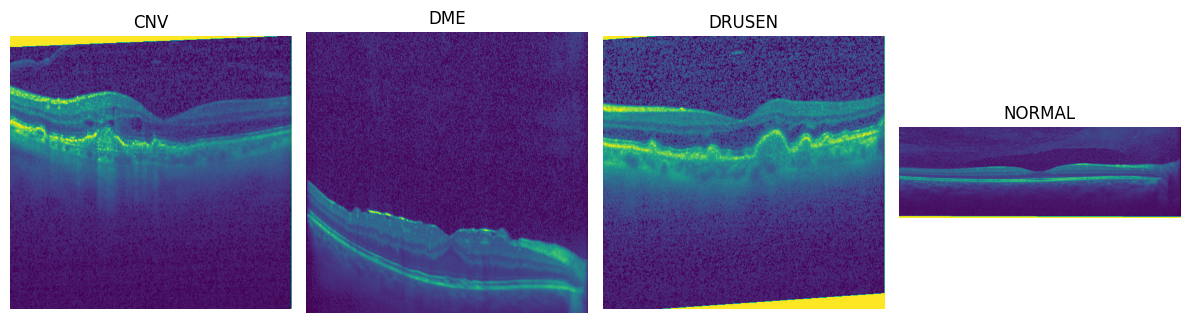

In [12]:
# Create a 2x2 subplot
fig, axs = plt.subplots(1, 4, figsize=(12, 5))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Ensure we don't try to plot more images than available axes
for i, ax in enumerate(axs):
    if i < len(diseases):
        disease = diseases[i]
        disease_dir = os.path.join(train_dir, disease)

        # List all images in the disease directory
        images = os.listdir(disease_dir)

        # Select a random image
        img_path = os.path.join(disease_dir, np.random.choice(images))

        # Load and display the image
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_title(disease)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

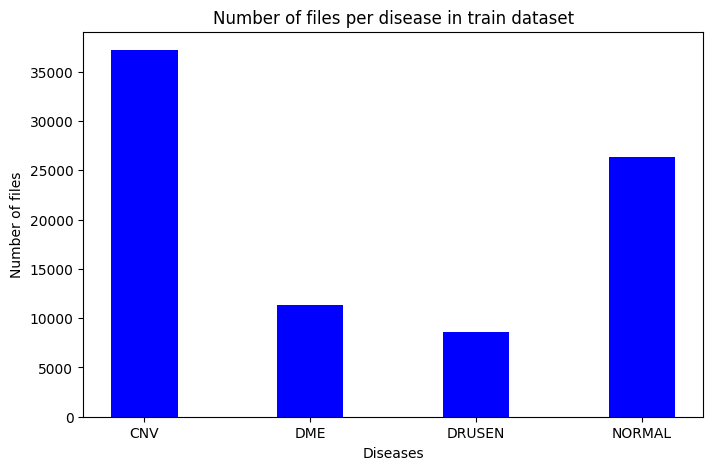

In [8]:
dataset = train_dir
image_counts = {"CNV": 0, "DME": 0, "DRUSEN": 0, "NORMAL": 0}

for disease in image_counts.keys():
    disease_dir = os.path.join(dataset, disease)
    image_counts[disease] = len(os.listdir(disease_dir))

diseases = list(image_counts.keys())
count = list(image_counts.values())

fig = plt.figure(figsize=(8,5))

plt.bar(diseases, count, color="blue", width = 0.4)

plt.xlabel("Diseases")
plt.ylabel("Number of files")
plt.title("Number of files per disease in train dataset")
plt.show()

# Training model using InceptionV3 pretrained model

In [6]:
batch_size = 32

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
image_gen = ImageDataGenerator(rescale=1/255,
                              shear_range=0.15,
                              zoom_range=0.2,
                              horizontal_flip=True,
                               rotation_range=25,
                              )

In [9]:
train_image_gen = image_gen.flow_from_directory(train_dir,
                                                target_size=(299, 299),
                                                batch_size=batch_size,
                                                color_mode="grayscale",
                                                shuffle=True,
                                                class_mode="categorical"
                                               )

Found 83484 images belonging to 4 classes.


In [10]:
test_image_gen = image_gen.flow_from_directory(test_dir,
                                                target_size=(299, 299),
                                                batch_size=batch_size,
                                                color_mode="grayscale",
                                                shuffle=False,
                                               class_mode="categorical"
                                               )

Found 968 images belonging to 4 classes.


In [11]:
loaded_model = load_model('../flask-app/models/InceptionV3_tuning.keras')

2024-09-27 10:47:02.368120: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-27 10:47:02.368148: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-27 10:47:02.368156: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-27 10:47:02.368172: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-27 10:47:02.368184: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
val_loss, val_accuracy = loaded_model.evaluate(test_image_gen)

print(f"Validation Accuracy: {val_accuracy:.2%}")

2024-09-27 10:47:14.274205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/eddiechen/Desktop/Projects/oct-disease/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 317ms/step - accuracy: 0.9953 - loss: 0.0239
Validation Accuracy: 99.59%


In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [31]:
# Define log directory
logdir = 'logs'

# TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='auto',
    patience=4,
    restore_best_weights=True
)

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='InceptionV3_tuning.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

In [34]:
loaded_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'] 
)

In [35]:
model_results = loaded_model.fit(train_image_gen,epochs=1,
                    validation_data=test_image_gen,
                    callbacks=[tensorboard_callback, early_stopping, checkpoint])

2024-09-26 23:23:40.492839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/eddiechen/Desktop/Projects/oct-disease/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1159/2609 ━━━━━━━━━━━━━━━━━━━━ 1:15:11 3s/step - accuracy: 0.9577 - loss: 0.1229

KeyboardInterrupt: 

In [56]:
val_loss, val_accuracy = loaded_model.evaluate(test_image_gen)

print(f"Validation Accuracy: {val_accuracy:.2%}")

/Users/eddiechen/Desktop/Projects/oct-disease/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 332ms/step - accuracy: 0.9956 - loss: 0.0278
Validation Accuracy: 99.48%


####

In [58]:
predictions = loaded_model.predict(test_image_gen)

31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 438ms/step


31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step


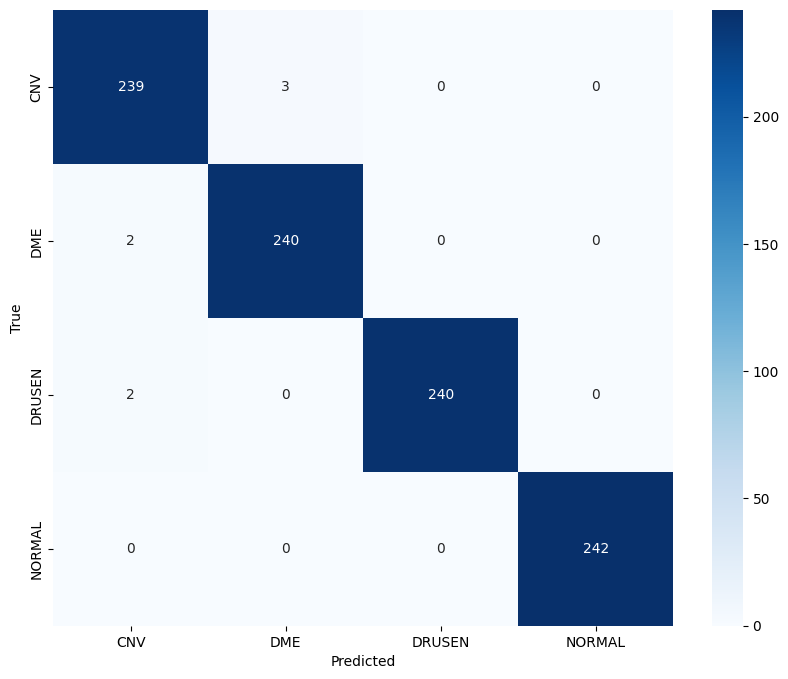

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
predictions = loaded_model.predict(test_image_gen)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_image_gen.classes

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_image_gen.class_indices.keys(), yticklabels=test_image_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Found 32 images belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


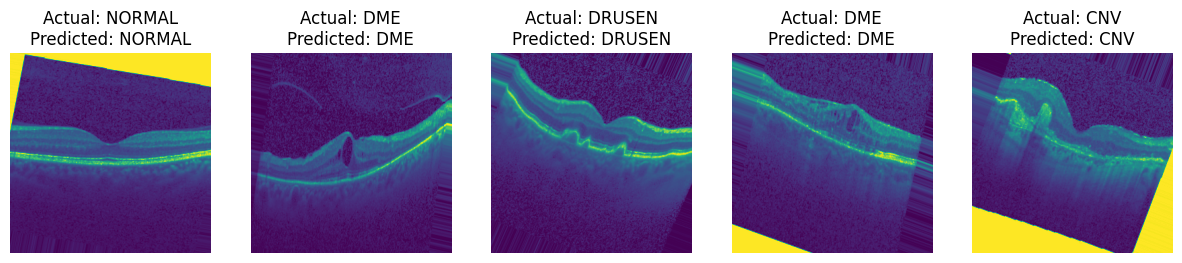

In [108]:
val_image_gen = image_gen.flow_from_directory(val_dir,                                          
                                              target_size=(299, 299),
                                                batch_size=batch_size,
                                                color_mode="grayscale",
                                                shuffle=True,
                                               class_mode="categorical"
                                               )


images, true_labels = next(val_image_gen)

# Predict the labels
predicted_labels = loaded_model.predict(images)
predicted_labels = np.argmax(predicted_labels, axis=1)  # Convert probabilities to class indices
true_labels = np.argmax(true_labels, axis=1)  # Convert one-hot encoded labels to class indices

# Get class labels 
class_labels = list(val_image_gen.class_indices.keys())

# Plot the images along with true and predicted labels
plt.figure(figsize=(15, 15))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Actual: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_labels[i]]}")
    plt.axis('off')

plt.show()

## Upload image for analysis

In [72]:
from tensorflow.keras.models import load_model 

model = load_model('InceptionV3_tuning.keras')

In [79]:
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
import numpy as np 

img = load_img('img_path', 
               target_size=(299, 299), 
                color_mode='grayscale')
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

In [80]:
image_gen = ImageDataGenerator(rescale=1/255,
                              shear_range=0.15,
                              zoom_range=0.2,
                              horizontal_flip=True,
                               rotation_range=25,
                              )

img_array = image_gen.flow(img_array, 
                           batch_size=1)

In [67]:
print(model.input_shape)

(None, 299, 299, 1)


In [82]:
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

class_labels = list(test_image_gen.class_indices.keys())

print(class_labels)

print(f"Predicted class: {class_labels[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
['CNV', 'DME', 'DRUSEN', 'NORMAL']
Predicted class: NORMAL
